## Imports

In [1]:
# !pip install imbalanced-learn
# !pip install xgboost
!pip install --upgrade holidays

You should consider upgrading via the 'C:\Users\catar\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
import seaborn as sns
import requests
import holidays

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV

C:\Users\catar\AppData\Local\Temp\ipykernel_11316\2005336699.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
## Know which packages i have installed
#pip freeze

## Read data

In [4]:
df_prod_sales = pd.read_csv("train/product_structures_sales.csv")
df_prices = pd.read_csv("train/product_prices_leaflets.csv")
df_chains = pd.read_csv("train/chain_campaigns.csv")

In [93]:
df_prod_sales['sku'].drop_duplicates().count()

3605

In [95]:
df_prod_sales.dtypes

structure_level_4            object
structure_level_3            object
structure_level_2            object
structure_level_1            object
sku                           int64
time_key                      int64
quantity                    float64
date                 datetime64[ns]
dtype: object

### Fix data types
- Create date_key column using time_key
- Structure levels as strings

In [6]:
df_prod_sales['date'] = pd.to_datetime(df_prod_sales['time_key'].astype(str), format='%Y%m%d')
df_prices['date'] = pd.to_datetime(df_prices['time_key'].astype(str), format='%Y%m%d')
df_chains['start_date'] = pd.to_datetime(df_chains['start_date'])
df_chains['end_date'] = pd.to_datetime(df_chains['end_date'])

df_prod_sales['structure_level_1'] = df_prod_sales['structure_level_1'].astype("str")
df_prod_sales['structure_level_2'] = df_prod_sales['structure_level_2'].astype("str")
df_prod_sales['structure_level_3'] = df_prod_sales['structure_level_3'].astype("str")
df_prod_sales['structure_level_4'] = df_prod_sales['structure_level_4'].astype("str")

### Combine given data

In [7]:
# Explode chain_campaigns by date
df_chains_date = df_chains.copy()
df_chains_date['date_range'] = df_chains_date.apply(lambda row: pd.date_range(start=row['start_date'], end=row['end_date']), axis=1)
df_chains_date = (df_chains_date.explode('date_range')
                                 .rename(columns={'date_range': 'date'})
                                 .drop(['start_date', 'end_date'], axis=1))

In [99]:
# Join the 3 datasets together
### keys: sku x time_key x competitor 
df = (df_prices.merge(df_prod_sales.drop('time_key', axis=1), on=['sku', 'date'], how='left')
               .merge(df_chains_date, on=['competitor', 'date'], how='left')
     )
## Add column pvp_is
df['pvp_is'] = df['pvp_was']*(1-df['discount'])

## ignora rows where quantity = 0 in company
df = df.dropna(subset=['quantity'])
df = df.drop('time_key', axis=1)

In [100]:
df['sku'].drop_duplicates().count()

3543

In [10]:
df.loc[((df.structure_level_1=='1'))]['sku'].drop_duplicates().count()

726

In [11]:
df.loc[((df.structure_level_1=='2'))]['sku'].drop_duplicates().count()

753

In [12]:
df.loc[((df.structure_level_1=='3'))]['sku'].drop_duplicates().count()

2064

In [9]:
df.loc[((df.sku==3578) & (df.date=='2024-03-01'))]

,sku,competitor,pvp_was,discount,flag_promo,leaflet,date,structure_level_4,structure_level_3,structure_level_2,structure_level_1,quantity,chain_campaign,pvp_is
1584788,3578,chain,64.05,0.0,0,NaN,2024-03-01,1020701,10207,102,1,5572.8144,C2,64.05
1696518,3578,competitorB,62.31,0.0,0,NaN,2024-03-01,1020701,10207,102,1,5572.8144,NaN,62.31
2549115,3578,competitorA,64.05,0.0,0,NaN,2024-03-01,1020701,10207,102,1,5572.8144,A2,64.05
2549116,3578,competitorA,64.05,0.0,0,NaN,2024-03-01,1020701,10207,102,1,5572.8144,A3,64.05


In [13]:
MIN_DATE = df['date'].min()
MAX_DATE = df['date'].max()

## Get new data

### Holidays

In [14]:
df_holidays = pd.DataFrame(holidays.Portugal(years=range(MIN_DATE.year,MAX_DATE.year+1),subdiv="11").items(), columns=["date", "holiday"])
df_holidays["date"] = pd.to_datetime(df_holidays["date"])

## Consider important holidays as Easter, Christmas and New Year
important_keywords = 'christmas|new year|easter'

df_holidays['holiday_importance'] = df_holidays['holiday'].str.lower().str.contains(important_keywords, regex=True)
df_holidays['holiday_importance'] = df_holidays['holiday_importance'].astype(int)+1

### Weather

In [15]:
try:
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": 39.6945,
        "longitude": -8.1306,
        "start_date": MIN_DATE.strftime('%Y-%m-%d'),
        "end_date": MAX_DATE.strftime('%Y-%m-%d'),
        "daily": ["apparent_temperature_mean", "precipitation_sum"],
        "timezone": "Europe/London"
    }
    r = requests.get(url, params=params)
    r.raise_for_status() 
    jsondata = r.json()
    daily_data = jsondata['daily']
    df_weather = (pd.DataFrame.from_dict(daily_data))
    ## Remove decimal cases
    df_weather['date'] = pd.to_datetime(df_weather['time'])
    df_weather['apparent_temperature_mean'] = df_weather['apparent_temperature_mean'].astype("int")
    df_weather['precipitation_sum'] = df_weather['precipitation_sum'].astype("int")
 
except requests.exceptions.HTTPError as errh: 
    print("HTTP Error while trying to extract weather info ")
    print(errh.args[0])
    raise
except requests.exceptions.ReadTimeout as errrt: 
    print("Time out while trying to extract weather info")
    print(errrt.args[0])
    raise
except requests.exceptions.ConnectionError as conerr: 
    print("Connection error while trying to extract weather info ") 
    print(conerr.args[0])
    raise

## Transform Data

### Fill missing days with closets regular price

In [80]:
all_dates = pd.DataFrame(pd.date_range(start=MIN_DATE, end=MAX_DATE, freq='D'), columns=["date"])

all_chain_campaigns = (pd.DataFrame(df[['date','competitor','chain_campaign']]
                        .drop_duplicates()))
all_sku_competitor = (pd.DataFrame(df[['structure_level_4','structure_level_3','structure_level_2','structure_level_1','sku', 'competitor']]
                        .drop_duplicates()))
all_quantity = (pd.DataFrame(df[['sku', 'date', 'quantity']]
                        .drop_duplicates()))

df_cross = (all_dates.merge(all_sku_competitor, how='cross')
                     .merge(all_chain_campaigns, on=['date', 'competitor'],how='left')
                     .merge(all_quantity, on=['sku', 'date'], how='left'))

df['flg_filled_gap'] = 0
df_filled = (df_cross.merge(df, 
                            on=['structure_level_4','structure_level_3','structure_level_2','structure_level_1','sku',
                                'date','competitor','chain_campaign', 'quantity'], 
                            how='left'))

df_filled[['discount','flag_promo', 'quantity']] = df_filled[['discount','flag_promo', 'quantity']].fillna(value=0)
df_filled[['flg_filled_gap']] = df_filled[['flg_filled_gap']].fillna(value=1)

## Fill pvp_was with the closest non null value by sku x competitor
df_filled = df_filled.sort_values(by=['sku','competitor', 'date'])
df_filled['pvp_was'] = df_filled.groupby('sku')['pvp_was'].ffill().bfill()
df_filled['pvp_is'] = np.where(df_filled['pvp_is'].isnull(), df_filled['pvp_was'], df_filled['pvp_is'])

### Add new features

#### Product classes

In [81]:
days_per_group = df.groupby('structure_level_1')['date'].nunique().reset_index()
days_per_group.columns = ['structure_level_1', 'n_days']

demand_stats = (
    df.groupby(['structure_level_1', 'sku'])
    .agg(count_days=('date', 'nunique'),
         quantity=('quantity', 'sum'))
    .reset_index()
)
demand_stats = demand_stats.merge(days_per_group, on='structure_level_1')
demand_stats['average_demand_interval'] = demand_stats['n_days'] / demand_stats['count_days']

# ABC classification
demand_stats['rank'] = demand_stats.groupby('structure_level_1')['quantity'] \
                                   .rank(method='first', ascending=False)
demand_stats = demand_stats.sort_values(['structure_level_1', 'rank'])
demand_stats['total_quantity'] = demand_stats.groupby('structure_level_1')['quantity'].transform('sum')
demand_stats['cumulative_quantity'] = demand_stats.groupby('structure_level_1')['quantity'].cumsum()
demand_stats['cumulative_pct'] = demand_stats['cumulative_quantity'] / demand_stats['total_quantity']
demand_stats['abc'] = np.select(
    [demand_stats['cumulative_pct'] <= 0.80,
     demand_stats['cumulative_pct'] <= 0.95],
    ['A', 'B'],
    default='C')

## XYZ classification
unique_dates = df['date'].drop_duplicates()
unique_sku_pairs = df[['structure_level_1', 'sku']].drop_duplicates()
sku_date_combinations = unique_sku_pairs.merge(unique_dates.to_frame(), how='cross')

df_slim = df[['structure_level_1', 'sku', 'date', 'quantity']]
df_full = sku_date_combinations.merge(df_slim, on=['structure_level_1', 'sku', 'date'], how='left')
df_full['quantity'] = df_full['quantity'].fillna(0)

sales_stats = (
    df_full.groupby(['structure_level_1', 'sku'])
    .agg(std_sales=('quantity', 'std'),
         avg_sales=('quantity', 'mean'))
    .reset_index())

sales_stats = sales_stats.merge(
    demand_stats[['structure_level_1', 'sku', 'average_demand_interval', 'abc']],
    on=['structure_level_1', 'sku'],
    how='left')

sales_stats['cv'] = sales_stats['std_sales'] / sales_stats['avg_sales']
sales_stats['cv_2'] = sales_stats['cv'] ** 2
sales_stats['xyz'] = np.select(
    [sales_stats['cv'] <= 0.5, sales_stats['cv'] <= 1],
    ['X', 'Y'],
    default='Z'
)

# SEIL classification
sales_stats['seil'] = np.select(
    [
        (sales_stats['average_demand_interval'] < 1.32) & (sales_stats['cv_2'] < 0.49),
        (sales_stats['average_demand_interval'] < 1.32) & (sales_stats['cv_2'] >= 0.49),
        (sales_stats['average_demand_interval'] >= 1.32) & (sales_stats['cv_2'] < 0.49)
    ],
    ['smooth', 'erratic', 'intermittent'],
    default='lumpy'
)

df_class = sales_stats[['structure_level_1', 'sku', 'abc', 'seil', 'xyz']]

#### Calendar features

In [82]:
df_filled['month'] = df_filled['date'].dt.month
df_filled['day_of_week'] = df_filled['date'].dt.dayofweek  # Monday=0, Sunday=6
df_filled['week_of_month'] = df_filled['date'].apply(lambda d: (d.day - 1) // 7 + 1)

#### Target Lag features

In [75]:
df_lag_data = df_filled[['sku', 'date', 'competitor', 'pvp_is', 'discount', 'flag_promo']].sort_values(["sku", "competitor", "date"]).drop_duplicates()

for lag in [1, 7, 30]:
    df_lag_data[f"pvp_is_lag_{lag}"] = df_lag_data.groupby(["sku", "competitor"])["pvp_is"].shift(lag)

for lag in [1, 7, 30]:
    df_lag_data[f"discount_lag_{lag}"] = df_lag_data.groupby(["sku", "competitor"])["discount"].shift(lag)

df_lag_data["days_since_last_promo"] = None  
for (sku, competitor), group in df_lag_data.groupby(["sku", "competitor"]):
    last_promo_date = None
    for idx, row in group.iterrows():
        if row["flag_promo"] == 1:
            df_lag_data.at[idx, "days_since_last_promo"] = 0
            last_promo_date = row["date"]
        elif last_promo_date:
            df_lag_data.at[idx, "days_since_last_promo"] = (row["date"] - last_promo_date).days
df_lag_data["days_since_last_promo"] = df_lag_data["days_since_last_promo"].astype("Int64")

df_lag_data["rolling_mean_7"] = df_lag_data.groupby(["sku", "competitor"])["pvp_is"].transform(lambda x: x.rolling(7, min_periods=1).mean())
df_lag_data["rolling_mean_30"] = df_lag_data.groupby(["sku", "competitor"])["pvp_is"].transform(lambda x: x.rolling(30, min_periods=1).mean())

In [76]:
df_lag_data = df_lag_data[['sku','date', 'competitor', 
                           'pvp_is_lag_1', 'pvp_is_lag_7', 'pvp_is_lag_30', 
                           'discount_lag_1', 'discount_lag_7', 'discount_lag_30', 
                           'days_since_last_promo', 'rolling_mean_7', 'rolling_mean_30']]

In [77]:
(df_lag_data.loc[((df_lag_data.sku.isin([4734])) & (df_lag_data.date>='2024-03-10')& (df_lag_data.date<='2024-04-10') & (df_lag_data.competitor=='chain'))]
 [['sku', 'date', 'competitor', 'flag_promo', 'discount', 'days_since_last_promo']].drop_duplicates())

KeyError: "['flag_promo', 'discount'] not in index"

#### Promo Participation and Avg Discount

In [71]:
df_avg_discount = df.copy()
df_avg_discount['discount_qty_pf1'] = (df_avg_discount['discount']*df_avg_discount['quantity']*df_avg_discount['flag_promo'])
df_avg_discount['qty_pf1'] = (df_avg_discount['quantity']*df_avg_discount['flag_promo'])
df_avg_discount = df_avg_discount.loc[((df_avg_discount['flag_promo']==1))]

df_avg_discount_L3 = (df_avg_discount.groupby(['structure_level_3', 'competitor'])
                                          .agg({'discount_qty_pf1': "sum",
                                                'qty_pf1': "sum",
                                                'discount': "mean"}))
df_avg_discount_L3['avg_discount_w_L3'] = df_avg_discount_L3['discount_qty_pf1']/df_avg_discount_L3['qty_pf1']
df_avg_discount_L3 = df_avg_discount_L3.rename(columns={'discount':'avg_discount'})[['avg_discount_w_L3']]
df_avg_discount_L3 = df_avg_discount_L3.reset_index()

df_avg_discount_sku = (df_avg_discount.groupby(['sku', 'competitor'])
                                          .agg({'discount_qty_pf1': "sum",
                                                'qty_pf1': "sum",
                                                'discount': "mean"}))
df_avg_discount_sku['avg_discount_w_sku'] = df_avg_discount_sku['discount_qty_pf1']/df_avg_discount_sku['qty_pf1']
df_avg_discount_sku = df_avg_discount_sku.rename(columns={'discount':'avg_discount'})[['avg_discount_w_sku']]
df_avg_discount_sku = df_avg_discount_sku.reset_index()

In [94]:
df_avg_discount_sku

,sku,competitor,avg_discount_w_sku
0,1128,chain,0.250700
1,1130,chain,0.200800
2,1133,chain,0.363600
3,1136,chain,0.200600
4,1136,competitorA,0.250500
...,...,...,...
5180,4733,competitorB,0.221509
5181,4734,chain,0.414374
5182,4734,competitorA,0.290641
5183,4735,chain,0.366042


In [72]:
df_pp = df.copy()
df_pp['qty_pf1'] = (df_pp['quantity']*df_pp['flag_promo'])
df_pp_L3 = (df_pp.groupby(['structure_level_3', 'competitor'])
              .agg(qty_pf1 = ("qty_pf1","sum"),
                   quantity = ("quantity","sum"),
                   count_pf1 = ("flag_promo","sum"),
                   count_all = ("flag_promo","count")))
df_pp_L3['promo_part_w_L3'] = df_pp_L3['qty_pf1']/df_pp_L3['quantity']
df_pp_L3['promo_part'] = df_pp_L3['count_pf1']/df_pp_L3['count_all']
df_pp_L3 = df_pp_L3[['promo_part_w_L3']]
df_pp_L3 = df_pp_L3.reset_index()

df_pp_sku = (df_pp.groupby(['sku', 'competitor'])
              .agg(qty_pf1 = ("qty_pf1","sum"),
                   quantity = ("quantity","sum"),
                   count_pf1 = ("flag_promo","sum"),
                   count_all = ("flag_promo","count")))
df_pp_sku['promo_part_w_sku'] = df_pp_sku['qty_pf1']/df_pp_sku['quantity']
df_pp_sku['promo_part'] = df_pp_sku['count_pf1']/df_pp_sku['count_all']
df_pp_sku = df_pp_sku[['promo_part_w_sku']]
df_pp_sku = df_pp_sku.reset_index()

In [104]:
df_pp_sku

,sku,competitor,promo_part_w_sku
0,1128,chain,1.000000
1,1128,competitorA,0.000000
2,1130,chain,1.000000
3,1132,chain,0.000000
4,1133,chain,0.477448
...,...,...,...
6739,4733,competitorB,0.433977
6740,4734,chain,0.878416
6741,4734,competitorA,0.563889
6742,4735,chain,0.379976


### Compile all data

In [83]:
df_new_filled = (df_filled.merge(df_holidays, on=['date'], how='left')
                          .merge(df_weather.drop('time', axis=1), on=['date'], how='left')
                          .merge(df_class, on=['structure_level_1','sku'], how='left')
                          .merge(df_lag_data, on=['sku','date', 'competitor'], how='left')
                          .merge(df_avg_discount_L3, on=['structure_level_3','competitor'], how='left')
                          .merge(df_pp_L3, on=['structure_level_3','competitor'], how='left')
                          .merge(df_avg_discount_sku, on=['sku','competitor'], how='left')
                          .merge(df_pp_sku, on=['sku','competitor'], how='left'))

## fill with nan non discount structL3
df_new_filled[['avg_discount_w_L3','promo_part_w_L3','avg_discount_w_sku','promo_part_w_sku']] = (df_new_filled[['avg_discount_w_L3','promo_part_w_L3','avg_discount_w_sku','promo_part_w_sku']]
                                                                                                  .fillna(value=0))

## limit discount values (fix errors)
df_new_filled['discount'] = df_new_filled['discount'].clip(lower=0)

## fill nan values
df_new_filled[['holiday']] = df_new_filled[['holiday']].fillna(value="")
df_new_filled[['leaflet']] = df_new_filled[['leaflet']].fillna(value="")
df_new_filled[['chain_campaign']] = df_new_filled[['chain_campaign']].fillna(value="")
df_new_filled[['holiday_importance']] = df_new_filled[['holiday_importance']].fillna(value=0)

## fix data types
df_new_filled['holiday_importance'] = df_new_filled['holiday_importance'].astype("int")

In [84]:
df_new_filled.isnull().sum().sort_values(ascending=False)

days_since_last_promo        1773979
pvp_is_lag_30                 204179
discount_lag_30               204179
discount_lag_7                 47623
pvp_is_lag_7                   47623
pvp_is_lag_1                    6744
discount_lag_1                  6744
precipitation_sum                  0
abc                                0
seil                               0
xyz                                0
date                               0
structure_level_4                  0
rolling_mean_7                     0
rolling_mean_30                    0
avg_discount_w_L3                  0
promo_part_w_L3                    0
avg_discount_w_sku                 0
apparent_temperature_mean          0
holiday_importance                 0
holiday                            0
week_of_month                      0
structure_level_3                  0
structure_level_2                  0
structure_level_1                  0
sku                                0
competitor                         0
c

### Convert data to modelling strucutre

In [86]:
df_chain_filled = df_new_filled.loc[df_new_filled.competitor=='chain']
df_chain_filled = df_chain_filled.rename(columns={"discount": "discount_chain","leaflet": "leaflet_chain"})

df_model_filled = df_new_filled.loc[df_new_filled.competitor!='chain']

df_model_filled = (df_model_filled.merge(df_chain_filled[['sku','date','discount_chain','leaflet_chain']], on=['sku','date'], how='left'))

In [87]:
df_model_filled.dtypes

date                         datetime64[ns]
structure_level_4                    object
structure_level_3                    object
structure_level_2                    object
structure_level_1                    object
sku                                   int64
competitor                           object
chain_campaign                       object
quantity                            float64
pvp_was                             float64
discount                            float64
flag_promo                          float64
leaflet                              object
pvp_is                              float64
flg_filled_gap                      float64
month                                 int32
day_of_week                           int32
week_of_month                         int64
holiday                              object
holiday_importance                    int32
apparent_temperature_mean             int32
precipitation_sum                     int32
abc                             

### Correlation Matrix

In [88]:
# Filter data for CompetitorA and CompetitorB
df_compA = df_model_filled[df_model_filled["competitor"] == "competitorA"]
df_compB = df_model_filled[df_model_filled["competitor"] == "competitorB"]

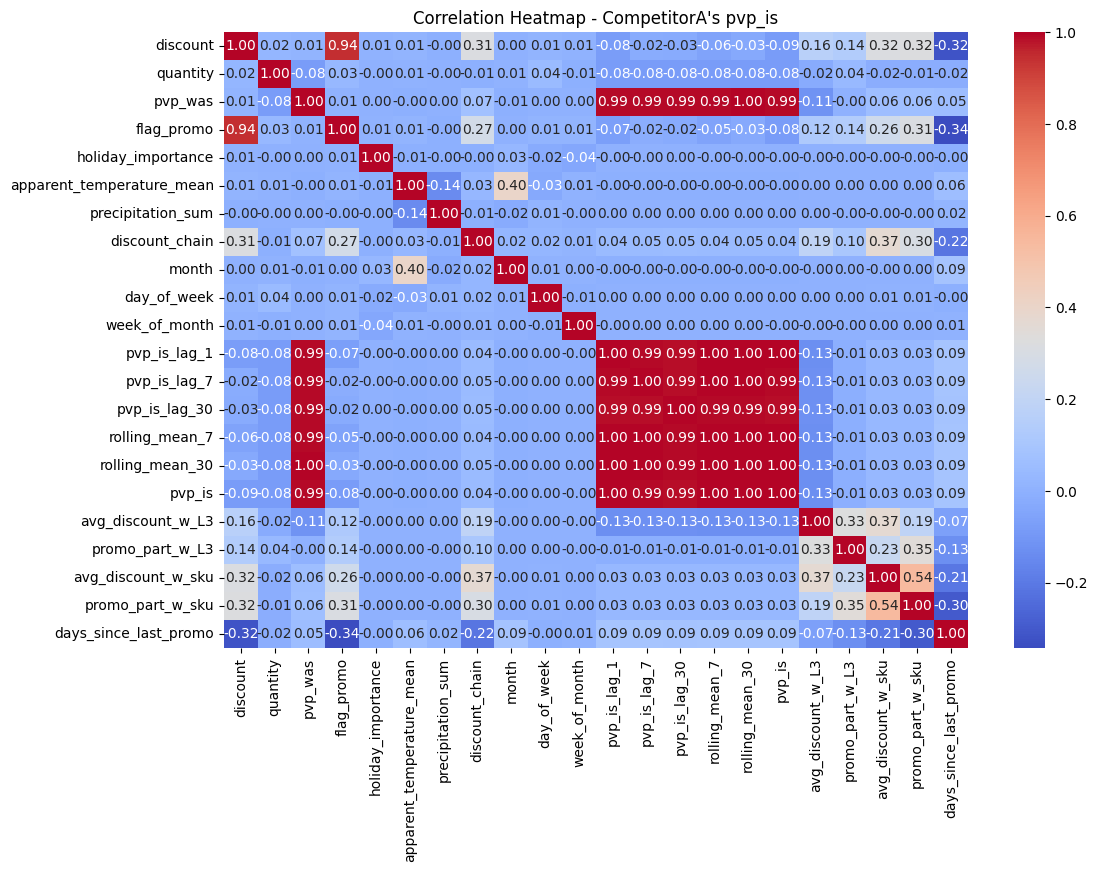

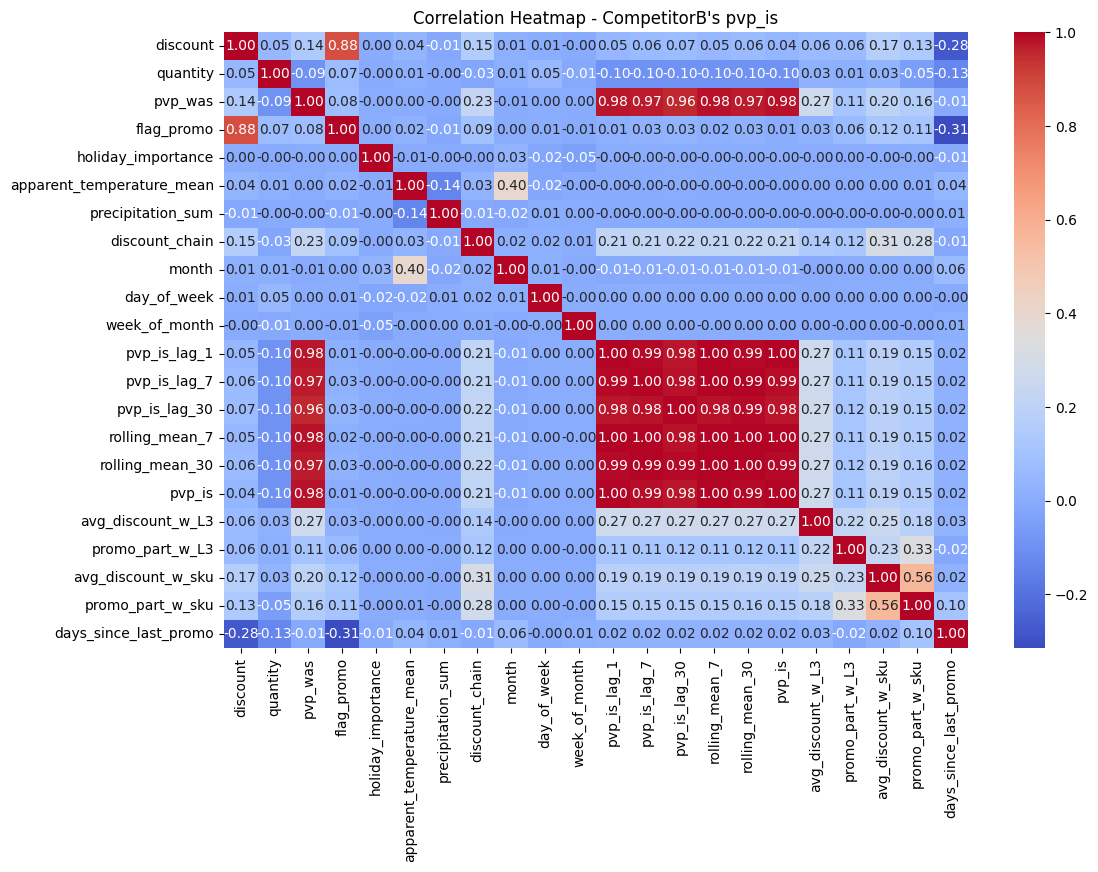

In [89]:


# Select only numerical columns for correlation
num_cols = ["discount", "quantity", "pvp_was", "flag_promo", "holiday_importance",
            "apparent_temperature_mean", "precipitation_sum", "discount_chain",
            "month", "day_of_week", "week_of_month", "pvp_is_lag_1", "pvp_is_lag_7", "pvp_is_lag_30", "rolling_mean_7", "rolling_mean_30", "pvp_is","avg_discount_w_L3", "promo_part_w_L3",
            "avg_discount_w_sku", "promo_part_w_sku", 'days_since_last_promo',]
# excluded_cols = ["sku", "date", "competitor"]
# num_cols = [col for col in df_processed.columns if col not in excluded_cols]
# Compute correlation matrices
corr_matrix_A = df_compA[num_cols].corr()
corr_matrix_B = df_compB[num_cols].corr()

# Function to plot heatmap
def plot_heatmap(corr_matrix, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title(title)
    plt.show()

# Plot heatmaps for each competitor
plot_heatmap(corr_matrix_A, "Correlation Heatmap - CompetitorA's pvp_is")
plot_heatmap(corr_matrix_B, "Correlation Heatmap - CompetitorB's pvp_is")

## Save data

In [90]:
print(df_model_filled.dtypes.to_string())

date                         datetime64[ns]
structure_level_4                    object
structure_level_3                    object
structure_level_2                    object
structure_level_1                    object
sku                                   int64
competitor                           object
chain_campaign                       object
quantity                            float64
pvp_was                             float64
discount                            float64
flag_promo                          float64
leaflet                              object
pvp_is                              float64
flg_filled_gap                      float64
month                                 int32
day_of_week                           int32
week_of_month                         int64
holiday                              object
holiday_importance                    int32
apparent_temperature_mean             int32
precipitation_sum                     int32
abc                             

In [91]:
df_model_filled.to_csv("prepared_data/data.csv", index=False)

In [94]:
df_model_filled['sku'].drop_duplicates().count()

2492

In [92]:
df_model_filled

,date,structure_level_4,structure_level_3,structure_level_2,structure_level_1,sku,competitor,chain_campaign,quantity,pvp_was,...,discount_lag_30,days_since_last_promo,rolling_mean_7,rolling_mean_30,avg_discount_w_L3,promo_part_w_L3,avg_discount_w_sku,promo_part_w_sku,discount_chain,leaflet_chain
0,2023-01-03,3020407,30204,302,3,1128,competitorA,,0.0000,76.20,...,NaN,<NA>,76.20,76.20,0.278562,0.159778,0.00000,0.000000,0.0,
1,2023-01-04,3020407,30204,302,3,1128,competitorA,,0.0000,76.20,...,NaN,<NA>,76.20,76.20,0.278562,0.159778,0.00000,0.000000,0.0,
2,2023-01-05,3020407,30204,302,3,1128,competitorA,,0.0000,76.20,...,NaN,<NA>,76.20,76.20,0.278562,0.159778,0.00000,0.000000,0.0,
3,2023-01-06,3020407,30204,302,3,1128,competitorA,,0.0000,76.20,...,NaN,<NA>,76.20,76.20,0.278562,0.159778,0.00000,0.000000,0.0,
4,2023-01-07,3020407,30204,302,3,1128,competitorA,,0.0000,76.20,...,NaN,<NA>,76.20,76.20,0.278562,0.159778,0.00000,0.000000,0.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2215741,2024-10-24,2020502,20205,202,2,4735,competitorA,,18.6840,55.37,...,0.0,346,55.37,55.37,0.234274,0.216204,0.36942,0.016338,0.0,
2215742,2024-10-25,2020502,20205,202,2,4735,competitorA,A2,24.9120,55.37,...,0.0,347,55.37,55.37,0.234274,0.216204,0.36942,0.016338,0.0,
2215743,2024-10-26,2020502,20205,202,2,4735,competitorA,A2,44.8416,55.37,...,0.0,348,55.37,55.37,0.234274,0.216204,0.36942,0.016338,0.0,
2215744,2024-10-27,2020502,20205,202,2,4735,competitorA,A2,32.3856,55.37,...,0.0,349,55.37,55.37,0.234274,0.216204,0.36942,0.016338,0.0,
